# Benchmark 2.0 

- This time, we are using a new database : SLKB, which has higher-quality, uniform data
- We are integrating the wilcox displacement estimate into the labeling of our positive results (which should have been done already)
- We will use no negative samples, instead relying on positive vs unlabeled samples
- Positive samples will be benchmarked against interactions found in n different cell lines
- SLKB uses different scoring systems with small overlap. 
  
- We will evaluate the overlap with each scoring system separately, at different thresholds : draw a heatmap table with one column per scoring system, and one row per score threshold, where each square is colored corresponding to the precision of the model.
- This heatmap can be redrawn for different p-value thresholds and numbers of cell lines

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# This excel file is the output of the model we want to benchmark

model_predictions = pd.read_excel("inputs/Supplementary_Table_11_CRISPR_DepMap_analysis.xlsx", sheet_name = None)

# We first extract the list of "mutant" genes included in our model, by getting the names of the tabs in the excel file, this will be used later
mutant_genes = model_predictions.keys()
mutant_genes_list = list(mutant_genes)

# Then, we extract a list of "ko" genes, which are simply all of the genes that each mutant (such as ARID1A) was tested against. 
# Of course, this also has to include ARID1A itself.
ko_genes_list = model_predictions['ARID1A']['gene'].tolist()
if 'ARID1A' not in ko_genes_list:
    ko_genes_list.append('ARID1A')

# Then, since the excel has multiple sheets, we concatenate them to obtain a single dataframe
model_predictions = pd.concat(
  [df for df in model_predictions.values()],
  ignore_index=True
)

model_predictions.head()

,mutant,gene,num_lines_high,num_lines_low,estimate,p_adj
0,ARID1A,EP300,98,98,-0.368858,8.644689e-08
1,ARID1A,MICOS10,98,98,-0.241643,7.014478e-07
2,ARID1A,PDCD10,98,98,-0.185685,2.418385e-06
3,ARID1A,SDHD,98,98,-0.236701,6.698955e-06
4,ARID1A,ROCK1,98,98,-0.115831,2.065706e-05


In [63]:
# This table, from SLKB, shows the calculated scores with 5 different scoring systems, among 22 different cell lines.
#
# Downloaded on 04/04/2025 from https://slkb.osubmi.org/

slkb_calculated_scores = pd.read_csv('inputs/SLKB_calculated_scores.csv')

# slkb_calculated_scores = slkb_calculated_scores[["gene_1", "gene_2", "study_origin", "cell_line_origin", "gemini_score_SL_score_Strong", "horlbeck_score_SL_score", "mageck_score_SL_score", "median_b_score_SL_score", "median_nb_score_SL_score", "sgrna_derived_b_score_SL_score", "sgrna_derived_nb_score_SL_score"]]

# Filtering in accordance with the SLKB paper, quoting :
# "Normally, Median-B and sgRNA-B scores are used in the Venn diagram, but Median-NB and sgRNA-NB scores are used if a study has no available dual-targeting controls."
slkb_calculated_scores["median_b/nb_score_SL_score"] = slkb_calculated_scores["median_b_score_SL_score"].fillna(
    slkb_calculated_scores["median_nb_score_SL_score"]
)
slkb_calculated_scores["sgrna_derived_b/nb_score_SL_score"] = slkb_calculated_scores["sgrna_derived_b_score_SL_score"].fillna(
    slkb_calculated_scores["sgrna_derived_nb_score_SL_score"]
)
slkb_calculated_scores = slkb_calculated_scores.drop(columns=[
    "median_b_score_SL_score",
    "median_nb_score_SL_score",
    "sgrna_derived_b_score_SL_score",
    "sgrna_derived_nb_score_SL_score"
])

print(slkb_calculated_scores.shape)
slkb_calculated_scores.head()

(261958, 19)


,Unnamed: 0,gene_1,gene_2,study_origin,cell_line_origin,gemini_score_SL_score_SensitiveLethality,gemini_score_SL_score_SensitiveRecovery,gemini_score_SL_score_Strong,horlbeck_score_SL_score,horlbeck_score_standard_error,mageck_score_SL_score,mageck_score_Z_SL_score,mageck_score_standard_error,median_b_score_Z_SL_score,median_b_score_standard_error,median_nb_score_Z_SL_score,median_nb_score_standard_error,median_b/nb_score_SL_score,sgrna_derived_b/nb_score_SL_score
0,1,AKT1,AMBRA1,33956155,RPE1,NaN,1.901398,-1.457454,-0.178004,0.155417,1.01035,1.683856,0.600022,2.614573,0.298490,3.470691,0.298490,0.780423,2.981263
1,2,AKT1,ATG10,33956155,RPE1,NaN,4.973365,-4.339744,-0.215414,0.083963,1.25735,4.267072,0.294663,2.169452,0.205642,3.412108,0.205642,0.446131,2.859691
2,3,AKT1,ATG101,33956155,RPE1,NaN,4.020508,-2.912154,0.141539,0.160130,1.58630,2.126466,0.745980,2.667042,0.465161,3.216406,0.465161,1.240603,3.582877
3,4,AKT1,ATG12,33956155,RPE1,NaN,3.665702,-3.021675,-0.168705,0.176245,1.66625,2.028864,0.821273,1.909342,0.471003,2.451892,0.471003,0.899307,2.169773
4,5,AKT1,ATG13,33956155,RPE1,NaN,3.160677,-2.216132,0.193127,0.220762,1.65970,3.181299,0.521705,2.378947,0.347413,3.114506,0.347413,0.826477,1.502438


In [71]:
# We can define custom score threshold values to classify SL and non-SL pairs

# Define thresholds
sl_percentile_thresh = 90   # top 100 - n %

# List of scoring systems 
scoring_systems_list = slkb_calculated_scores.columns[5:].to_list()
print(scoring_systems_list)

# Initialize DataFrames with gene identifiers
calc_slkb_predictions = slkb_calculated_scores[["gene_1", "gene_2", "cell_line_origin"]].copy()
calc_slkb_predictions.rename(columns={"gene_1":"gene1", "gene_2":"gene2"}, inplace=True)

# Iterate through each scoring system
for scoring_system in scoring_systems_list:
    print(slkb_calculated_scores[scoring_system].describe())
    sl_cutoff = np.percentile(slkb_calculated_scores[scoring_system], sl_percentile_thresh)
    print(sl_cutoff)
    calc_slkb_predictions[scoring_system] = (slkb_calculated_scores[scoring_system] >= sl_cutoff).astype(int)
 
# # Finally, we filter it to only include the gene pairs where one of the studied genes is a "mutant" from our dataset, and the other is a ko gene
# slkb_predictions = slkb_predictions[
#     ((slkb_predictions["gene1"].isin(mutant_genes_list)) & slkb_predictions["gene2"].isin(ko_genes_list)) |
#     ((slkb_predictions["gene2"].isin(mutant_genes_list)) & slkb_predictions["gene1"].isin(ko_genes_list))
# ]

for scoring_system in scoring_systems_list:
    # Filter rows where at least one scoring system has a score of 1
    calc_filtered_slkb_predictions = calc_slkb_predictions[
        (calc_slkb_predictions["gene1"] == "SMARCA4") | 
        (calc_slkb_predictions["gene2"] == "SMARCA4")
    ]

    calc_filtered_slkb_predictions = calc_filtered_slkb_predictions[calc_filtered_slkb_predictions[scoring_system] == 1]
    print(calc_filtered_slkb_predictions)

['gemini_score_SL_score_SensitiveLethality', 'gemini_score_SL_score_SensitiveRecovery', 'gemini_score_SL_score_Strong', 'horlbeck_score_SL_score', 'horlbeck_score_standard_error', 'mageck_score_SL_score', 'mageck_score_Z_SL_score', 'mageck_score_standard_error', 'median_b_score_Z_SL_score', 'median_b_score_standard_error', 'median_nb_score_Z_SL_score', 'median_nb_score_standard_error', 'median_b/nb_score_SL_score', 'sgrna_derived_b/nb_score_SL_score']
count    236003.000000
mean          0.078589
std           0.582055
min          -5.341261
25%          -0.202688
50%           0.029587
75%           0.384191
max           4.763233
Name: gemini_score_SL_score_SensitiveLethality, dtype: float64
nan
count    25955.000000
mean        -0.003964
std          0.580296
min         -2.580592
25%         -0.288363
50%         -0.058090
75%          0.152484
max          5.330273
Name: gemini_score_SL_score_SensitiveRecovery, dtype: float64
nan
count    261958.000000
mean          0.041771
std  

In [54]:
# This table, from SLKB, shows which SL pairs scored within the top 10% of 5 different scoring systems, among 22 different cell lines.
#
# Downloaded on 04/04/2025 from https://slkb.osubmi.org/, specifically here https://slkb.osubmi.org/session/00b5c112434073acd4ea9e9668422bec/download/download_data-predSL?w= 

slkb_predictions = pd.read_excel("inputs/SLKB_predictions.xlsx", sheet_name=None)

# Here, we also have to concatenate the different sheets
slkb_predictions = pd.concat(
  [df.assign(cell_line=name) for name, df in slkb_predictions.items()],
  ignore_index=True
)

# We separate the "gene_pair" column into two separate columns, to match the format of our first table
slkb_predictions[["gene1", "gene2"]] = slkb_predictions["gene_pair"].str.split('|', expand=True)
slkb_predictions.drop(columns="gene_pair", inplace=True)

# Finally, we filter it to only include the gene pairs where one of the studied genes is a "mutant" from our dataset, and the other is a ko gene
slkb_predictions = slkb_predictions[
    ((slkb_predictions["gene1"].isin(mutant_genes_list)) & slkb_predictions["gene2"].isin(ko_genes_list)) |
    ((slkb_predictions["gene2"].isin(mutant_genes_list)) & slkb_predictions["gene1"].isin(ko_genes_list))
]

# Filter rows where at least one scoring system has a score of 1
filtered_slkb_predictions = slkb_predictions[
    (slkb_predictions["gene1"] == "SMARCA4") | 
    (slkb_predictions["gene2"] == "SMARCA4")
]

filtered_slkb_predictions = filtered_slkb_predictions[filtered_slkb_predictions["MAGECK-Score"] == 1]

filtered_slkb_predictions

,GEMINI-Score,HORLBECK-Score,MAGECK-Score,MEDIAN-B/NB Score,sgRNA-Derived B/NB Score,total_count,cell_line,gene1,gene2
441,1,0,1,0,1,3,28319113_293T,CDK9,SMARCA4
466,0,0,1,1,1,3,28319113_293T,ERBB2,SMARCA4
649,1,0,1,0,0,2,28319113_293T,KDM5C,SMARCA4
687,0,0,1,0,1,2,28319113_293T,PIK3R1,SMARCA4
703,1,0,1,0,0,2,28319113_293T,SMARCA4,SMARCB1
1025,0,0,1,0,0,1,28319113_293T,EGFR,SMARCA4
1295,0,1,1,1,1,4,28319113_A549,CDK9,SMARCA4
1310,0,1,1,1,1,4,28319113_A549,MAP3K1,SMARCA4
1312,1,0,1,1,1,4,28319113_A549,RPS6KB1,SMARCA4
1356,0,1,1,0,1,3,28319113_A549,FGFR3,SMARCA4


### Positive classification conditions for our model : 
- Wilcox displacement estimate over 0.15
- p-value under 1e-3 or 1e-4 (to be adjusted)
- for the gene pairs that were tested multiple times, one positive classification is sufficient

### SLKB conditions for positive classification
- It depends on the scoring system
- It depends on the number of cell lines in which it's been identified (2+)

In [6]:
def get_confusion_sets(p_adj_treshold, scoring_system, num_cell_lines, print_tables=False):
    # Step 1: Get predicted SLIs
    hits_data = model_predictions[(model_predictions["estimate"] < -0.15) & (model_predictions["p_adj"] < p_adj_treshold)].copy()
    hits_data[["mutant", "gene"]] = hits_data[["mutant", "gene"]].apply(lambda row: sorted(row), axis=1, result_type="expand")
    hits_data = hits_data.rename(columns={"mutant": "gene1", "gene": "gene2"})
    predicted_pairs = set(map(tuple, hits_data[["gene1", "gene2"]].drop_duplicates().values))

    # Step 2: Get benchmark positives (known SLIs from scoring system)
    positive_results = slkb_predictions[slkb_predictions[scoring_system] == 1].copy()
    positive_results[["gene1", "gene2"]] = positive_results[["gene1", "gene2"]].apply(lambda row: sorted(row), axis=1, result_type="expand")
    positive_results_count = positive_results.groupby(["gene1", "gene2"]).sum().reset_index()
    known_pairs = set(map(tuple, positive_results_count[positive_results_count[scoring_system] >= num_cell_lines][["gene1", "gene2"]].values))

    # Step 3: Compute confusion matrix sets
    true_positives = predicted_pairs & known_pairs
    false_positives = predicted_pairs - known_pairs
    false_negatives = known_pairs - predicted_pairs

    # Optional: true negatives require knowing the universe of tested gene pairs
    all_pairs = set(map(tuple, slkb_predictions[["gene1", "gene2"]].apply(sorted, axis=1).drop_duplicates()))
    true_negatives = all_pairs - (true_positives | false_positives | false_negatives)

    if print_tables:
        print("True Positives (TP):", len(true_positives))
        print("False Positives (FP):", len(false_positives))
        print("False Negatives (FN):", len(false_negatives))
        print("True Negatives (TN):", len(true_negatives))

    return {
        "TP": true_positives,
        "FP": false_positives,
        "FN": false_negatives,
        "TN": true_negatives
    }


def get_recall(p_adj_treshold, scoring_system, num_cell_lines):
    confusion = get_confusion_sets(p_adj_treshold, scoring_system, num_cell_lines)
    TP = len(confusion["TP"])
    FN = len(confusion["FN"])
    recall = TP / (TP + FN) if (TP + FN) > 0 else None
    return recall


def get_precision(p_adj_treshold, scoring_system, num_cell_lines):
    confusion = get_confusion_sets(p_adj_treshold, scoring_system, num_cell_lines)
    TP = len(confusion["TP"])
    FP = len(confusion["FP"])
    precision = TP / (TP + FP) if (TP + FP) > 0 else None
    return precision

precision = get_precision(p_adj_treshold=0.0001, scoring_system="gemini_score_SL_score_Strong", num_cell_lines=1)
recall = get_recall(p_adj_treshold=0.0001, scoring_system="gemini_score_SL_score_Strong", num_cell_lines=1)
print(precision, recall)

0.0 0.0


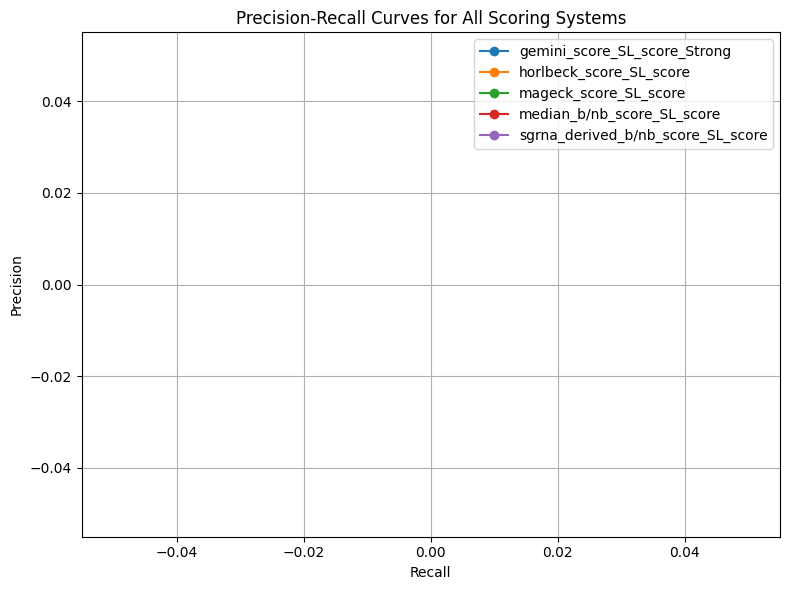

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the p-value thresholds
p_adj_thresholds = np.linspace(0, 0.05, 100)

# Set number of required supporting cell lines for ground truth
num_cell_lines = 3

plt.figure(figsize=(8, 6))

# Loop through each scoring system
for scoring_system in scoring_systems_list:
    precisions = []
    recalls = []

    for thresh in p_adj_thresholds:
        precision = get_precision(thresh, scoring_system, num_cell_lines)
        recall = get_recall(thresh, scoring_system, num_cell_lines)
        
        if precision is not None and recall is not None:
            precisions.append(precision)
            recalls.append(recall)

    plt.plot(recalls, precisions, marker='o', label=scoring_system)

# Final plot adjustments
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curves for All Scoring Systems")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Now, we want to generate a heatmap for different scoring systems and cell line numbers
def draw_precision_recall_table(p_adj_treshold, cell_line_numbers=[1, 2, 3, 4, 5]):
    hit_rates_dict = {}
    hit_rates_dict["num_cell_lines"] = cell_line_numbers
    for scoring_system in scoring_systems_list:
        # Create a column containing the precision for all cell line numbers
        column_name = scoring_system + "_Precision"
        hit_rates_dict[column_name] = []
        for num_cell_lines in cell_line_numbers:
            hit_rates_dict[column_name].append(get_precision(p_adj_treshold, scoring_system, num_cell_lines))

        # Create a column containing the recall for all cell line numbers
        column_name = scoring_system + "_Recall"
        hit_rates_dict[column_name] = []
        for num_cell_lines in cell_line_numbers:
            hit_rates_dict[column_name].append(get_recall(p_adj_treshold, scoring_system, num_cell_lines))

    hit_rates_df = pd.DataFrame(hit_rates_dict)
    return hit_rates_df

p_adj_treshold = 0.001
hit_rates_df = draw_precision_recall_table(p_adj_treshold)

hit_rates_df

,num_cell_lines,GEMINI-Score_Precision,GEMINI-Score_Recall,HORLBECK-Score_Precision,HORLBECK-Score_Recall,MAGECK-Score_Precision,MAGECK-Score_Recall,MEDIAN-B/NB Score_Precision,MEDIAN-B/NB Score_Recall,sgRNA-Derived B/NB Score_Precision,sgRNA-Derived B/NB Score_Recall
0,1,0.008696,0.016529,0.008696,0.011561,0.004348,0.008065,0.004348,0.008696,0.008696,0.01626
1,2,0.004348,0.052632,0.004348,0.052632,0.004348,0.111111,0.000000,0.000000,0.004348,0.06250
2,3,0.004348,0.200000,0.004348,0.500000,0.004348,0.500000,0.000000,0.000000,0.004348,0.50000
3,4,0.000000,0.000000,0.004348,1.000000,0.004348,1.000000,0.000000,NaN,0.004348,1.00000
4,5,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN


In [8]:
p_adj_treshold = 0.001
scoring_system = "GEMINI-Score"
num_cell_lines = 1
get_positives_list(p_adj_treshold, scoring_system, num_cell_lines, print_tables=True)
hit_rate = get_hit_rate(p_adj_treshold, scoring_system, num_cell_lines)
print(hit_rate)

NameError: name 'get_positives_list' is not defined

It seems that the only gene pair on SLKB that was labeled in 4 or more cell lines by any score was SMARCA2/SMARCA4, which incidentally happens to be labeled by the model. Let's see what other pairs are on SLKB if we remove the filter for "mutant" genes : it may give us additional pairs to try

In [ ]:
# With the same code from the beginning, we generate a 2nd table where we filter differently to keep all gene pairs that contain 2 "ko" genes instead of "mutants"

# This table, from SLKB, shows which SL pairs scored within the top 10% of 5 different scoring systems, among 22 different cell lines.
#
# Downloaded on 04/04/2025 from https://slkb.osubmi.org/, specifically here https://slkb.osubmi.org/session/00b5c112434073acd4ea9e9668422bec/download/download_data-predSL?w= 

slkb_predictions2 = pd.read_excel("inputs/SLKB_predictions.xlsx", sheet_name=None)

# Here, we also have to concatenate the different sheets
slkb_predictions2 = pd.concat(
  [df.assign(cell_line=name) for name, df in slkb_predictions2.items()],
  ignore_index=True
)

# We separate the "gene_pair" column into two separate columns, to match the format of our first table
slkb_predictions2[["gene1", "gene2"]] = slkb_predictions2["gene_pair"].str.split('|', expand=True)
slkb_predictions2.drop(columns="gene_pair", inplace=True)

# Finally, we filter it to only include the gene pairs where one of the studied genes is a "mutant" from our dataset, and the other is a ko gene
slkb_predictions2 = slkb_predictions2[
    ((slkb_predictions2["gene1"].isin(ko_genes_list)) & slkb_predictions2["gene2"].isin(ko_genes_list))
]

slkb_predictions2.head()

,GEMINI-Score,HORLBECK-Score,MAGECK-Score,MEDIAN-B/NB Score,sgRNA-Derived B/NB Score,total_count,cell_line,gene1,gene2
0,1,1,1,1,1,5,26864203_OVCAR8,KDM1B,MBD1
1,1,1,1,1,1,5,26864203_OVCAR8,KDM4A,KDM5A
2,1,1,1,1,1,5,26864203_OVCAR8,KDM4C,KDM5A
3,1,1,1,0,1,4,26864203_OVCAR8,BMI1,KDM1B
4,0,1,1,1,1,4,26864203_OVCAR8,CREBBP,ING5


In [ ]:
def get_positives_list_enlarged(p_adj_treshold, scoring_system, num_cell_lines, print_tables=False):
    # Get the list of "hit pairs" at a given adjusted p-value threshold, where the estimate is under -0.15 (since the sign was inverted by the model)
    hits_data = model_predictions[(model_predictions["estimate"] < -0.15) & (model_predictions["p_adj"] < p_adj_treshold)].copy()

    # Normalize hits_data
    hits_data[["mutant", "gene"]] = hits_data[["mutant", "gene"]].apply(lambda row: sorted(row), axis=1, result_type="expand")
    hits_data = hits_data.rename(columns={"mutant": "gene1", "gene": "gene2"})
    hits_data_unique = hits_data[["gene1", "gene2"]].drop_duplicates()

    # Find positive results
    positive_results = slkb_predictions2[slkb_predictions2[scoring_system] == 1]

    # Normalize gene pairs
    positive_results_normalized = positive_results.copy()
    positive_results_normalized[["gene1", "gene2"]] = (
        positive_results_normalized[["gene1", "gene2"]]
        .apply(lambda row: sorted(row), axis=1, result_type="expand")
    )

    # Group by the normalized pairs and add the number of positive results
    positive_results_count = positive_results_normalized.groupby(["gene1", "gene2"]).sum().reset_index()

    # Filter to keep only the results that have been found in num_cell_lines cell lines
    positive_benchmark_df = positive_results_count[positive_results_count[scoring_system] >= num_cell_lines]

    # Convert both to sets of tuples
    predicted_pairs = set(map(tuple, hits_data_unique[["gene1", "gene2"]].values))
    known_pairs = set(map(tuple, positive_benchmark_df[["gene1", "gene2"]].values))
    true_positives = predicted_pairs & known_pairs

    if print_tables:
        print("true positives :  \n", true_positives, "\n\n known pairs:  \n", known_pairs, "\n\n predicted pairs:  \n", predicted_pairs) 

    return known_pairs, true_positives

In [ ]:
p_adj_treshold = 0.0001
scoring_system = "HORLBECK-Score"
num_cell_lines = 10
get_positives_list_enlarged(p_adj_treshold, scoring_system, num_cell_lines, print_tables=True)
hit_rate = get_hit_rate(p_adj_treshold, scoring_system, num_cell_lines)
print(hit_rate)

true positives :  
 set() 

 known pairs:  
 {('CDK4', 'CDK6'), ('CSNK2A1', 'CSNK2A2'), ('HK1', 'HK2'), ('HDAC1', 'HDAC2'), ('MARK2', 'MARK3'), ('BCL2L1', 'MCL1'), ('MAP2K1', 'MAP2K2'), ('PIP5K1A', 'PIP5K1C'), ('RPS6KB1', 'SGK2'), ('MAPK1', 'MAPK3'), ('UBE2A', 'UBE2B')} 

 predicted pairs:  
 {('EFR3A', 'PBRM1'), ('EP300', 'SMARCA4'), ('DROSHA', 'SMARCA4'), ('COA5', 'SMARCB1'), ('COA5', 'SMARCA4'), ('ARID1A', 'SDHD'), ('PBRM1', 'SEC61G'), ('ARID1A', 'EP300'), ('FECH', 'SMARCA4'), ('ARID1B', 'CDS2'), ('SDHC', 'SMARCA4'), ('SMARCA4', 'TTC27'), ('PSMB5', 'SMARCA2'), ('PBRM1', 'RBM18'), ('ARID2', 'CCNF'), ('SDHA', 'SMARCA4'), ('CBFB', 'SMARCB1'), ('CBFB', 'SMARCA4'), ('FECH', 'SETD2'), ('CDAN1', 'SMARCA4'), ('ARHGEF7', 'PBRM1'), ('ARID2', 'COX5B'), ('COQ4', 'SMARCA4'), ('KLF5', 'PBRM1'), ('KMT2D', 'MICOS10'), ('MRPS26', 'SMARCA4'), ('HGS', 'PBRM1'), ('PBRM1', 'RRAGC'), ('GCSH', 'KMT2D'), ('PDCD10', 'SMARCB1'), ('ARID1A', 'ATP1B3'), ('NXT1', 'SMARCA4'), ('CDIN1', 'SMARCA4'), ('ARID1A', 'PDC

In [ ]:
known_pairs = {('KCNH3', 'KCNH4'), ('MMP20', 'MMP9'), ('USP15', 'USP4'), ('KCNA10', 'KCNA7'), ('CAPN1', 'CAPN11'), ('ATP2B1', 'ATP2B4'), ('CHEK1', 'WEE1'), ('FGR', 'YES1'), ('PLXNA1', 'PLXND1'), ('MAP2K2', 'MAP2K3'), ('EGFR', 'ERBB3'), ('PRMT1', 'PRMT6'), ('PRMT3', 'PRMT6'), ('MMP15', 'MMP8'), ('KDM5B', 'KDM5C'), ('GZMH', 'GZMM'), ('AKT1', 'AKT3'), ('ADAM33', 'ADAM9'), ('EPHA10', 'EPHA8'), ('EPHB1', 'EPHB6'), ('PFKFB2', 'PFKFB4'), ('CES1', 'CES3'), ('ACHE', 'CES1'), ('PIP4K2C', 'PIP5K1A'), ('ADAMTS20', 'ADAMTS4'), ('LIPA', 'LIPM'), ('CAMK2B', 'CAMK2G'), ('USP24', 'USP9X'), ('ACSM3', 'ACSM4'), ('MAPK1', 'WEE1'), ('KCNA2', 'KCNA7'), ('SOX10', 'SOX9'), ('KCNF1', 'KCNS2'), ('BAD', 'BMF'), ('HK1', 'HK2'), ('ADAM19', 'ADAM9'), ('PIK3R2', 'PIK3R3'), ('MOGAT1', 'MOGAT2'), ('ATP12A', 'ATP1A1'), ('KCNB2', 'KCNG1'), ('LIPA', 'LIPJ'), ('PIP4K2B', 'PIP5K1A'), ('PRKCD', 'PRKCE'), ('MMP8', 'MMP9'), ('PRKCI', 'PRKCZ'), ('RPS6KB1', 'RPS6KB2'), ('TRIM11', 'TRIM21'), ('ACSM3', 'ACSM5'), ('PLA2G4D', 'PLA2G4F'), ('TRIM11', 'TRIM39'), ('CPD', 'CPN1'), ('RPS6KA1', 'RPS6KB1'), ('B3GNT2', 'B3GNT9'), ('NEDD4L', 'SMURF2'), ('LRP1', 'LRP2'), ('ADAM12', 'ADAM9'), ('SRPK1', 'SRPK2'), ('BCL2L1', 'MAPK1'), ('TRIM11', 'TRIM38'), ('GNB4', 'GNB5'), ('FBXL19', 'KDM2A'), ('KLHL13', 'KLHL9'), ('KCNB2', 'KCNS2'), ('CPD', 'CPM'), ('KDM4A', 'KDM4C'), ('MAPK14', 'MAPK9'), ('MTMR4', 'MTMR6'), ('GSPT1', 'GSPT2'), ('BAD', 'BAX'), ('HDAC1', 'HDAC2'), ('KCNA1', 'KCNA7'), ('RPS6KA1', 'RPS6KA3'), ('CSK', 'ITK'), ('MAPK11', 'MAPK13'), ('F10', 'PROC'), ('UBE2A', 'UBE2B'), ('LCK', 'LYN'), ('BAX', 'BMF'), ('KCNA10', 'KCNA2'), ('CTSF', 'CTSH'), ('DAPK2', 'DAPK3'), ('ADAM12', 'ADAM15'), ('LRP2', 'LRP4'), ('SRMS', 'YES1'), ('BCL2L1', 'BRCA2'), ('TRIM17', 'TRIM38'), ('KCNA1', 'KCNA10'), ('KEAP1', 'KLHL20'), ('TRAF2', 'TRAF3'), ('CAPN1', 'CAPN3'), ('TRIM38', 'TRIM68'), ('DGAT2', 'MOGAT2'), ('ARSA', 'ARSH'), ('DNM1', 'DNM1L'), ('PRKCB', 'PRKCD'), ('CAPN11', 'CAPN3'), ('MTM1', 'MTMR2'), ('ROCK1', 'ROCK2'), ('UBE2L3', 'UBE2L6'), ('ATP8A1', 'ATP8B2'), ('MTMR6', 'MTMR8'), ('PRKCA', 'PRKCZ'), ('ADAMTS17', 'ADAMTS7'), ('RPS6KA5', 'RPS6KB1'), ('B3GNT2', 'B3GNT3'), ('AKT1', 'RPS6KB1'), ('EPHA7', 'EPHB4'), ('ATP8A1', 'ATP8B3'), ('CCL23', 'CCL5'), ('EPHB4', 'EPHB6'), ('MTMR6', 'MTMR9'), ('AKT1', 'RPS6KA4'), ('ADAMTS4', 'ADAMTS8'), ('PLCB4', 'PLCZ1'), ('SLC27A1', 'SLC27A3'), ('SLC27A1', 'SLC27A4'), ('LPCAT2', 'LPCAT4'), ('PLA2G4B', 'PLA2G4D'), ('TBL1X', 'TBL1XR1'), ('GRK5', 'GRK7'), ('KCNH2', 'KCNH4'), ('ARSD', 'ARSH'), ('KCNH4', 'KCNH5'), ('MAPK13', 'MAPK14'), ('DGKB', 'DGKE'), ('PARP1', 'WEE1'), ('ADAMTS18', 'ADAMTS7'), ('PRKCE', 'PRKCZ'), ('KLHL22', 'KLHL9'), ('BRCA2', 'WEE1'), ('WNK1', 'WNK3'), ('ADAM21', 'ADAM9'), ('CAPN11', 'CAPN2'), ('MAP2K1', 'MAP2K2'), ('EPHA8', 'EPHB4'), ('LPA', 'PLAU'), ('ACSM1', 'ACSM3'), ('KLK2', 'KLK3'), ('AKT2', 'RPS6KB1'), ('BRCA2', 'PARP1'), ('PRKCA', 'PRKCD'), ('PIAS1', 'PIAS3'), ('ATP11B', 'ATP8A2'), ('MMP7', 'MMP9'), ('RPS6KA1', 'SGK2'), ('TRIM11', 'TRIM27'), ('PRKCA', 'PRKCI'), ('KDM3A', 'KDM3B'), ('EPHA2', 'EPHA8'), ('PAFAH1B1', 'WDR5'), ('RPS6KA3', 'RPS6KB1'), ('ACADS', 'ACADSB'), ('BMF', 'PMAIP1'), ('NEK2', 'NEK7'), ('CSNK1A1', 'CSNK1D'), ('EPHA5', 'EPHA8'), ('GSPT1', 'HBS1L'), ('PTPRA', 'PTPRF'), ('PFKFB2', 'PFKFB3'), ('GALNT1', 'GALNT4'), ('SRC', 'YES1'), ('DUSP1', 'DUSP2'), ('PAK2', 'PAK3'), ('MTOR', 'WEE1'), ('MMP1', 'MMP16'), ('PAK3', 'PAK4'), ('ACADS', 'ACADVL'), ('PRKCA', 'PRKCB'), ('KCNG1', 'KCNS3'), ('PAK1', 'PAK2'), ('PKN1', 'PKN2'), ('MMP10', 'MMP9'), ('B3GNT3', 'B3GNT9'), ('BIRC2', 'BIRC3'), ('LATS1', 'LATS2'), ('BCL2L1', 'PARP1'), ('CTSH', 'CTSS'), ('ATP2C1', 'ATP2C2'), ('PLCB2', 'PLCZ1'), ('MAP2K3', 'MAP2K6'), ('CSNK2A1', 'CSNK2A2'), ('CDK4', 'CDK6'), ('PPP6R1', 'PPP6R3'), ('RPS6KA4', 'RPS6KB1'), ('KCNA10', 'KCNC3'), ('PPP2R5C', 'PPP2R5D'), ('DGAT2L6', 'MOGAT2'), ('GZMB', 'GZMH'), ('TRIM38', 'TRIM4'), ('BRCA2', 'CHEK1'), ('CAPN11', 'CAPN9'), ('ARF4', 'ARF5'), ('BMF', 'BNIP3L'), ('CSK', 'FES'), ('WDR5', 'WDR83'), ('AKT1', 'SGK2'), ('PLCB1', 'PLCB3'), ('CES1', 'CES2'), ('PIK3CA', 'PIK3CB'), ('FGR', 'SRMS'), ('PRKCA', 'PRKCE'), ('CDC25A', 'CDC25B'), ('PSMB5', 'PSMB8'), ('KCNH1', 'KCNH4'), ('DUSP4', 'DUSP6'), ('EPHA8', 'EPHB6'), ('EPHA8', 'EPHB3'), ('YWHAE', 'YWHAZ'), ('CAMK2G', 'CAMK4'), ('CAPN12', 'CAPN3'), ('BLK', 'SRC'), ('EGFR', 'ERBB2'), ('AURKA', 'AURKB'), ('CAPN3', 'CAPN9'), ('BRAF', 'RAF1'), ('ATP8A1', 'ATP8B4'), ('GALNT11', 'GALNT16'), ('MMP2', 'MMP9'), ('TRIM28', 'TRIM33'), ('PPIL1', 'PPWD1'), ('TRIM39', 'TRIM68'), ('CAPN2', 'CAPN3'), ('RPS6KB2', 'SGK2'), ('SGK2', 'SGK3'), ('EPHA7', 'EPHA8'), ('CDK1', 'CDK2'), ('GALNT13', 'GALNT16'), ('BRCA1', 'WEE1'), ('SMARCA2', 'SMARCA4'), ('MAP4K4', 'MINK1'), ('PPIH', 'PPWD1'), ('AKT2', 'SGK2'), ('MMP1', 'MMP2'), ('PRKCD', 'PRKCZ'), ('CCL3', 'CCL5'), ('PLA2G1B', 'PLA2G2E'), ('KCNA10', 'KCNA3'), ('SMURF1', 'SMURF2'), ('ELOVL4', 'ELOVL5'), ('ATP1A1', 'ATP1A4'), ('EPHA8', 'EPHB2'), ('ADAM30', 'ADAM9'), ('BRCA2', 'MTOR'), ('CHP1', 'PPP3R1'), ('PTPRA', 'PTPRK'), ('TGFBR1', 'TGFBR2'), ('CASP3', 'CASP8'), ('EPHA8', 'EPHB1'), ('MARK2', 'MARK3'), ('GZMB', 'GZMM'), ('PLXNA3', 'PLXND1'), ('PIP5K1A', 'PIP5K1C'), ('FUT5', 'FUT6'), ('TRIM11', 'TRIM68'), ('CPA3', 'CPB1'), ('DAPK3', 'MYLK'), ('KCNB1', 'KCNB2'), ('PLXNB1', 'PLXND1'), ('MAPK12', 'MAPK13'), ('KEAP1', 'KLHL5'), ('TUBB', 'TUBB4B'), ('MAPK1', 'MAPK3'), ('ATP11B', 'ATP8A1'), ('CES2', 'NLGN1'), ('ATP6V0A1', 'ATP6V0A2'), ('PLCB2', 'PLCB3'), ('MMP1', 'MMP25'), ('LYN', 'SRMS'), ('KCNA2', 'KCNA3'), ('KLHL12', 'KLHL20'), ('AKT2', 'AKT3'), ('CSNK1D', 'CSNK1E'), ('KCNG1', 'KCNV1'), ('LCK', 'YES1'), ('CSK', 'FER'), ('MOGAT2', 'MOGAT3'), ('PRKACA', 'PRKACB'), ('EHMT1', 'SUV39H1'), ('TRIM21', 'TRIM38'), ('MOB1A', 'MOB1B'), ('ATP8A1', 'ATP8A2'), ('ACSM2A', 'ACSM3'), ('ATP12A', 'ATP1A4'), ('ACADS', 'IVD'), ('MMP15', 'MMP25'), ('RPS6KB1', 'SGK2'), ('LATS2', 'STK38'), ('PLXNA4', 'PLXND1'), ('TRIM11', 'TRIM4'), ('ENPEP', 'NPEPPS'), ('PRPS1', 'PRPS2'), ('MMP25', 'MMP8'), ('BCL2L1', 'MCL1')} 

import csv
# Export to CSV
with open('SLKB_known_pairs_4_cell_lines.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['mutant', 'gene'])
    for mutant, gene in known_pairs:
        writer.writerow([mutant, gene])

known_pairs = {('BCL2L1', 'MCL1'), ('UBE2A', 'UBE2B'), ('CDK4', 'CDK6'), ('CSNK2A1', 'CSNK2A2'), ('RPS6KB1', 'SGK2'), ('MAP2K1', 'MAP2K2'), ('MAPK1', 'MAPK3'), ('PIP5K1A', 'PIP5K1C'), ('HDAC1', 'HDAC2'), ('MARK2', 'MARK3'), ('HK1', 'HK2')}
# Export to CSV
with open('SLKB_known_pairs_10_cell_lines.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['mutant', 'gene'])
    for mutant, gene in known_pairs:
        writer.writerow([mutant, gene])

It looks like out of 268 different pairs detected in at least 4 cell lines, only 4 or 5 are detectable by the algorithm (tested in a separate notebook).